<a href="https://colab.research.google.com/github/Sreelekshmi688582/project/blob/main/Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# importing libraries

import pandas as pd
import numpy as np

import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re
import string

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
train = pd.read_csv('://httpsraw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/tweets_dataset.csv', index_col=0)
print(train.shape)
train.head()

(7102, 4)


code  ... weight
0  10000  ...  0.938
1  10001  ...  0.896
2  10002  ...  0.896
3  10003  ...  0.896
4  10004  ...  0.896

[5 rows x 4 columns]

In [58]:
# missing value check
def missing_value_check(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df

In [59]:
missing_value_check(train)

column_name  percent_missing
code    code        0.0            
text    text        0.0            
label   label       0.0            
weight  weight      0.0

In [60]:
train['text'] = train['text'] .str.replace('&amp', '')

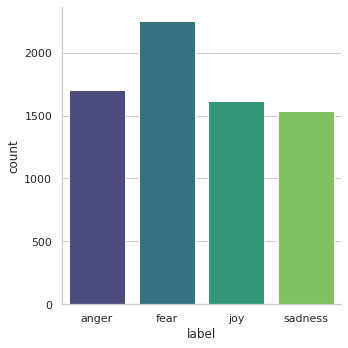

In [61]:
# plotting the distribution of emotions
sns.catplot(x="label", kind="count", palette="viridis", data=train)

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize(label):
    words = ''
    for tweet in train[train['label'] == label]['text']:
        tweet = tweet.lower()
        words += tweet + ' '
    wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='white').generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

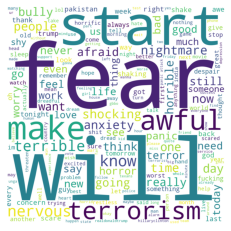

In [63]:
visualize('fear')

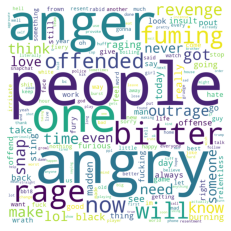

In [64]:
visualize('anger')

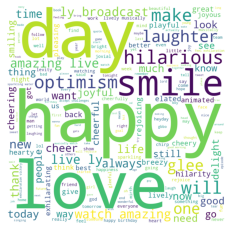

In [65]:
visualize('joy')

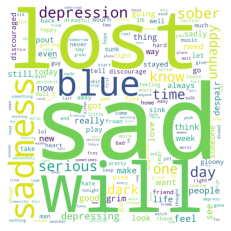

In [66]:
visualize('sadness')

In [67]:
# splitting into training and development sets
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

In [68]:
# uploading song lyrics dataset 
lyrics = pd.read_csv('https://raw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/song_lyrics_final_manually_labeled.csv', index_col =0)
lyrics['song_lyrics'] = lyrics['song_lyrics'].str.replace('EmbedShare URLCopyEmbedCopy', '')
lyrics = lyrics.rename(columns={'song_lyrics': "text"})
lyrics = lyrics.drop_duplicates()
print(lyrics.shape)

(600, 9)


In [69]:
# 40 manually labeled songs for testing
X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']
X_test_lyrics.shape

(40, 9)

In [70]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, english stopwords
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = stopwords.words("english")
        stop = stop + list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [71]:
# Tf-IDF: unigrams and bigrams
tfidf_uni_bi = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='word',
                tokenizer=word_tokenize,
                ngram_range = (1,2))

In [72]:
# TF-IDF: char analyzer (3,6)
tfidf_char = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='char',
                ngram_range = (3,6))

In [73]:
# creating pipelines
pipe_cleaning = Pipeline([('clean', CleanText())])                      
                
pipe_extract_word = Pipeline([('clean', CleanText()), ('tfidf', tfidf_uni_bi)])

pipe_extract_char = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char),
                              ("select", SelectKBest(score_func = chi2, k=15000))])

pipe_extract_char2 = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char)])

In [74]:
tfidf_matrix_train_word = pipe_extract_word.fit_transform(X_train)
tfidf_matrix_test_word = pipe_extract_word.transform(X_test)
print(tfidf_matrix_train_word.shape)
print(tfidf_matrix_test_word.shape)

(5326, 10970)
(1776, 10970)


In [75]:
tfidf_matrix_train_char = pipe_extract_char.fit_transform(X_train, y_train)
tfidf_matrix_test_char = pipe_extract_char.transform(X_test)
print(tfidf_matrix_train_char.shape)
print(tfidf_matrix_test_char.shape)

(5326, 15000)
(1776, 15000)


In [76]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_word.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 8149)


In [77]:
tfidf_matrix_train_char2 = pipe_extract_char2.fit_transform(X_train, y_train)
tfidf_matrix_test_char2 = pipe_extract_char2.transform(X_test)
print(tfidf_matrix_train_char2.shape)
print(tfidf_matrix_test_char2.shape)

(5326, 112987)
(1776, 112987)


In [78]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_char2.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 99816)


In [79]:
cv = RepeatedKFold(n_splits=10, n_repeats= 5, random_state=1)

Accuracy score in validation set is,  0.868 with standard deviation =  0.0131 


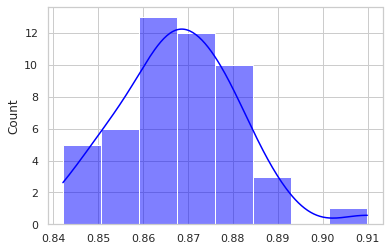

In [80]:
model = LogisticRegression()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [81]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.83      0.87       426
        fear       0.81      0.93      0.86       563
         joy       0.94      0.90      0.92       404
     sadness       0.86      0.80      0.83       383

    accuracy                           0.87      1776
   macro avg       0.88      0.86      0.87      1776
weighted avg       0.87      0.87      0.87      1776



In [82]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.71      0.50      0.59        10
        fear       0.45      0.50      0.48        10
         joy       0.78      0.70      0.74        10
     sadness       0.54      0.70      0.61        10

    accuracy                           0.60        40
   macro avg       0.62      0.60      0.60        40
weighted avg       0.62      0.60      0.60        40



Accuracy score in validation set is,  0.858 with standard deviation =  0.0155 


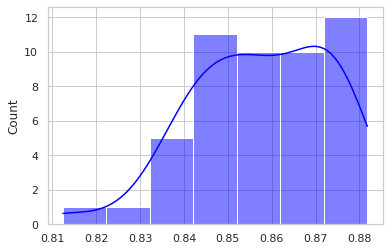

In [83]:
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [84]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.90      0.80      0.85       426
        fear       0.76      0.93      0.84       563
         joy       0.93      0.89      0.91       404
     sadness       0.87      0.74      0.80       383

    accuracy                           0.85      1776
   macro avg       0.86      0.84      0.85      1776
weighted avg       0.86      0.85      0.85      1776



In [85]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.88      0.70      0.78        10
        fear       0.47      0.80      0.59        10
         joy       0.67      0.60      0.63        10
     sadness       0.67      0.40      0.50        10

    accuracy                           0.62        40
   macro avg       0.67      0.62      0.63        40
weighted avg       0.67      0.62      0.63        40



Accuracy score in validation set is,  0.865 with standard deviation =  0.0144 


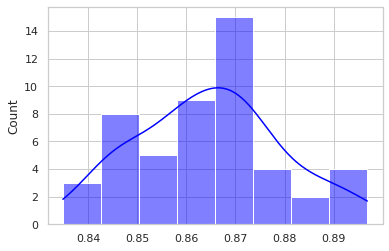

In [86]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [87]:
pipe_svm = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SVC())])

pipe_svm.fit(X=X_train, y=y_train)
y_preds = pipe_svm.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.85      0.88       426
        fear       0.81      0.93      0.87       563
         joy       0.95      0.90      0.92       404
     sadness       0.87      0.78      0.82       383

    accuracy                           0.87      1776
   macro avg       0.88      0.87      0.87      1776
weighted avg       0.88      0.87      0.87      1776



In [88]:
y_pred_lyrics = pipe_svm.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.45      0.50      0.48        10
        fear       0.50      0.60      0.55        10
         joy       0.86      0.60      0.71        10
     sadness       0.50      0.50      0.50        10

    accuracy                           0.55        40
   macro avg       0.58      0.55      0.56        40
weighted avg       0.58      0.55      0.56        40



Accuracy score in validation set is,  0.894 with standard deviation =  0.0138 


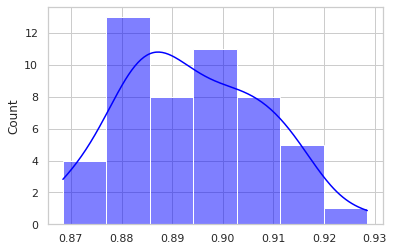

In [89]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [90]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.87      0.89       426
        fear       0.87      0.89      0.88       563
         joy       0.91      0.93      0.92       404
     sadness       0.84      0.84      0.84       383

    accuracy                           0.88      1776
   macro avg       0.88      0.88      0.88      1776
weighted avg       0.88      0.88      0.88      1776



In [91]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.60      0.60      0.60        10
        fear       0.67      0.40      0.50        10
         joy       0.78      0.70      0.74        10
     sadness       0.47      0.70      0.56        10

    accuracy                           0.60        40
   macro avg       0.63      0.60      0.60        40
weighted avg       0.63      0.60      0.60        40



Accuracy score in validation set is,  0.878 with standard deviation =  0.0146 


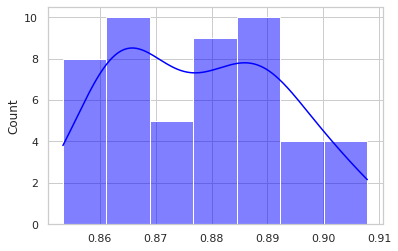

In [92]:
model = SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced')
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [93]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.87      0.82      0.85       426
        fear       0.83      0.88      0.86       563
         joy       0.91      0.91      0.91       404
     sadness       0.84      0.83      0.83       383

    accuracy                           0.86      1776
   macro avg       0.86      0.86      0.86      1776
weighted avg       0.86      0.86      0.86      1776



['anger', 'fear', 'joy', 'sadness']


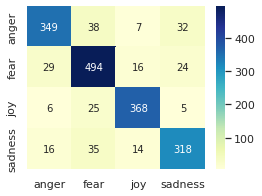

In [94]:
# confusion matrix for dev set
categories = list(set(list(train['label'])))
categories.sort()
print(categories)
df_cm  = pd.DataFrame(confusion_matrix(y_test, y_preds), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

In [95]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report( y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.73      0.80      0.76        10
        fear       0.60      0.60      0.60        10
         joy       0.71      0.50      0.59        10
     sadness       0.58      0.70      0.64        10

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



['anger', 'fear', 'joy', 'sadness']


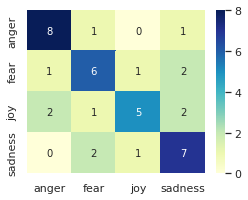

In [96]:
# confusion matrix for test set with song lyrics
categories = list(set(y_train))
categories.sort()
print(categories)
df_cm_lyrics  = pd.DataFrame(confusion_matrix(y_test_lyrics, y_pred_lyrics), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm_lyrics, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

In [97]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, stopwords not removed
class CleanText2( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

# creating pipelines
pipe_cleaning_stop = Pipeline([('clean', CleanText2())])

In [98]:
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']

In [99]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each tweet/song
MAX_SEQUENCE_LENGTH = 1000
# emdedding dimensions
EMBEDDING_DIM = 200

In [100]:
X_train['cleaned_text'] =  pipe_cleaning.fit_transform(X_train)
X_test['cleaned_text'] = pipe_cleaning.transform(X_test)
X_test_lyrics['cleaned_text'] = pipe_cleaning.transform(X_test_lyrics)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_train.shape)

X_test = tokenizer.texts_to_sequences(X_test['cleaned_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

X_test_lyrics = tokenizer.texts_to_sequences(X_test_lyrics['cleaned_text'].values)
X_test_lyrics = pad_sequences(X_test_lyrics, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test lyrics data tensor:', X_test_lyrics.shape)

Y_train = pd.get_dummies(y_train).values
print('Shape of train label tensor:', Y_train.shape)

Y_test= pd.get_dummies(y_test).values
print('Shape of test label tensor:', Y_test.shape)

Y_test_lyrics= pd.get_dummies(y_test_lyrics).values
print('Shape of test lyrics label tensor:', Y_test_lyrics.shape)

Found 11856 unique tokens.
Shape of train data tensor: (5326, 1000)
Shape of test data tensor: (1776, 1000)
Shape of test lyrics data tensor: (40, 1000)
Shape of train label tensor: (5326, 4)
Shape of test label tensor: (1776, 4)
Shape of test lyrics label tensor: (40, 4)


In [101]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         4000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 200)        0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 4,120,804
Trainable params: 4,120,804
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 249s 6s/step - loss: 1.3406 - accuracy: 0.3390 - val_loss: 1.2394 - val_accuracy: 0.4447
Epoch 2/5
38/38 [==============================] - 242s 6s/step - loss: 0.9204 - accuracy: 0.7288 - val_loss: 0.7613 - val_accuracy: 0.7711
Epoch 3/5
38/38 [==============================] - 249s 7s/step - loss: 0.3243 - accuracy: 0.9301 - val_loss: 0.4799 - val_accuracy: 0.8518
Epoch 4/5
38/38 [==============================] - 246s 6s/step - loss: 0.1267 - accuracy: 0.9602 - val_loss: 0.4718 - val_accuracy: 0.8518
Epoch 5/5
38/38 [==============================] - 247s 7s/step - loss: 0.0880 - accuracy: 0.9697 - val_loss: 0.4233 - val_accuracy: 0.8705


In [48]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test tweets: {:0.3f}'.format(accr[0],accr[1]))

56/56 [==============================] - 19s 341ms/step - loss: 0.4448 - accuracy: 0.8637
Test set
  Loss: 0.445
  Accuracy test tweets: 0.864


In [49]:
accr = model.evaluate(X_test_lyrics,Y_test_lyrics)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test lyrics: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 1s 210ms/step - loss: 1.8344 - accuracy: 0.4500
Test set
  Loss: 1.834
  Accuracy test lyrics: 0.450


In [50]:
# predicting talikng the best classifier
best_classifier = pipe_sgd
lyrics['text'] = lyrics['text'].astype(str)
y_pred_lyrics_all = pipe_sgd.predict(lyrics)
lyrics['emotion_pred'] = y_pred_lyrics_all

In [51]:
# SGD probablity score
y_score = pipe_sgd.predict_proba(lyrics)
score_emot_selected = np.round(np.amax(y_score, 1)*1, 2)
score_emot_selected.shape
lyrics['emotion_score'] = score_emot_selected

In [52]:
lyrics_genres = lyrics.groupby('genre')['emotion_pred'].value_counts(normalize=True).reset_index(name='percentage')

In [53]:
# percentage of emotion classed predicted in the lyrics dataset
lyrics['emotion_pred'].value_counts(normalize=True)

sadness    0.338333
fear       0.265000
joy        0.215000
anger      0.181667
Name: emotion_pred, dtype: float64

In [54]:
# percentage of emotion classed predicted in the lyrics dataset by genres
lyrics_genres

genre emotion_pred  percentage
0   Alternative Rock/Indie  fear         0.312500  
1   Alternative Rock/Indie  anger        0.250000  
2   Alternative Rock/Indie  sadness      0.250000  
3   Alternative Rock/Indie  joy          0.187500  
4   Blues                   sadness      0.500000  
5   Blues                   fear         0.250000  
6   Blues                   anger        0.150000  
7   Blues                   joy          0.100000  
8   Classic Rock            sadness      0.360000  
9   Classic Rock            fear         0.280000  
10  Classic Rock            joy          0.240000  
11  Classic Rock            anger        0.120000  
12  Country                 sadness      0.400000  
13  Country                 joy          0.250000  
14  Country                 fear         0.200000  
15  Country                 anger        0.150000  
16  Electronic/Dance        fear         0.371429  
17  Electronic/Dance        sadness      0.257143  
18  Electronic/Dance        joy          0.200000  
19  Electronic/Dance        anger        0.171429  
20  Folk                    joy          0.366667  
21  Folk                    sadness      0.300000  
22  Folk                    fear         0.233333  
23  Folk                    anger        0.100000  
24  Hard Rock               sadness      0.377778  
25  Hard Rock               joy          0.288889  
26  Hard Rock               fear         0.200000  
27  Hard Rock               anger        0.133333  
28  Hip-hop/Rap             sadness      0.320000  
29  Hip-hop/Rap             anger        0.260000  
30  Hip-hop/Rap             fear         0.240000  
31  Hip-hop/Rap             joy          0.180000  
32  Jazz                    sadness      0.480000  
33  Jazz                    anger        0.240000  
34  Jazz                    fear         0.160000  
35  Jazz                    joy          0.120000  
36  Metal                   sadness      0.500000  
37  Metal                   fear         0.200000  
38  Metal                   anger        0.160000  
39  Metal                   joy          0.140000  
40  Pop                     fear         0.327273  
41  Pop                     sadness      0.272727  
42  Pop                     joy          0.227273  
43  Pop                     anger        0.172727  
44  Punk Rock               sadness      0.340000  
45  Punk Rock               fear         0.280000  
46  Punk Rock               anger        0.200000  
47  Punk Rock               joy          0.180000  
48  R&B/Soul                joy          0.466667  
49  R&B/Soul                sadness      0.266667  
50  R&B/Soul                anger        0.200000  
51  R&B/Soul                fear         0.066667  
52  Reggae                  sadness      0.400000  
53  Reggae                  fear         0.250000  
54  Reggae                  joy          0.200000  
55  Reggae                  anger        0.150000

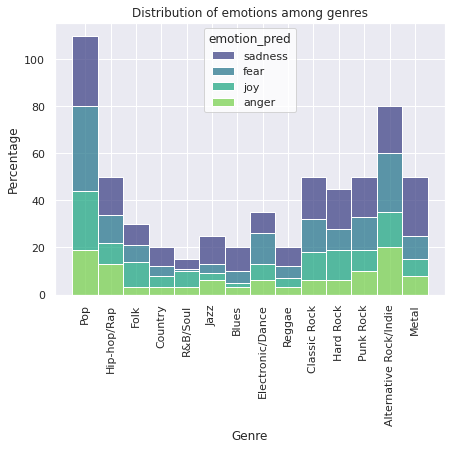

In [55]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.set_style("white")

sns.histplot(data=lyrics, ax=ax, stat="count", multiple="stack",
             x="genre", kde=False,
             palette='viridis', hue="emotion_pred",
             element="bars", legend=True)
ax.set_title("Distribution of emotions among genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.tick_params(axis='x', rotation=90)

In [102]:
## EDA Pkgs
import pandas as pd
#Data Viz Pkg
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import numpy as np # linear algebra
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
# Load Dataset
df = pd.read_csv("tweets_dataset.csv")
# Preview
df.head(3)

Unnamed: 0   code  ...  label weight
0  0           10000  ...  anger  0.938
1  1           10001  ...  anger  0.896
2  2           10002  ...  anger  0.896

[3 rows x 5 columns]

In [105]:
!pip install neattext
# Load Text Cleaning Package
import neattext.functions as nfx

     |████████████████████████████████| 114 kB 5.1 MB/s 


In [106]:
# Cleaning Text
df['clean_tweet'] = df['text'].apply(nfx.remove_hashtags)
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: nfx.remove_userhandles(x))
# Cleaning Text: Multiple WhiteSpaces
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_multiple_spaces)
# Cleaning Text : Remove urls
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_urls)
# Cleaning Text: Punctuations
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_puncts)
#Remove blank rows if any.
df['clean_tweet'] .dropna(inplace=True)
# Change all the text to lower case.
df['clean_tweet']  = [entry.lower() for entry in df['clean_tweet'] ]
df[['text','clean_tweet']]

text                                                                                                                                        clean_tweet
0     How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##                                                                  how the fu*k who the heck moved my fridge should i knock the landlord door                                                                       
1     So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted                                           so my indian uber driver just called someone the n word if i wasnt in a moving vehicle id have jumped out                                        
2     @DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice                                                       i asked for my parcel to be delivered to a pick up store not my address                                                                         
3     so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #angry #upset #tired #sad #tired #hangry ######                            so ef whichever butt wipe pulled the fire alarm in davis bc i was sound asleep                                                                   
4     Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! #fuming                                     dont join they put the phone down on you talk over you and are rude taking money out of my acc willynilly                                        
5     My blood is boiling                                                                                                                                               my blood is boiling                                                                                                                              
6     When you've still got a whole season of Wentworth to watch and a stupid cunt in work ruins it for us 😭😭 @__KirstyGA #raging #oldcunt                              when youve still got a whole season of wentworth to watch and a stupid cunt in work ruins it for us 😭😭                                           
7     @bt_uk why does tracking show my equipment delivered, when it wasn't? Why is my service suddenly delayed? We've already 3 weeks. #fuming                           why does tracking show my equipment delivered when it wasnt why is my service suddenly delayed weve already 3 weeks                             
8     @TeamShanny legit why i am so furious with him, people are such fucking idiots.                                                                                    legit why i am so furious with him people are such fucking idiots                                                                               
9     How is it suppose to work if you do that? Wtf dude? Thanks for pissing me off.                                                                                    how is it suppose to work if you do that wtf dude thanks for pissing me off                                                                      
10    im so mad about power rangers. im incensed. im furious.                                                                                                           im so mad about power rangers im incensed im furious                                                                                             
11    Wont use using @mothercareuk @Mothercarehelp again!! These guys cant get nothing right!! #fuming                                                                  wont use using again these guys cant get nothing right                                                                                           
12    Bitches aggravate like what inspires you to be the biggest cunt known to m

In [107]:
# Tokenization
df['clean_tweet']= [word_tokenize(entry) for entry in df['clean_tweet']]
df['clean_tweet']

0       [how, the, fu*k, who, the, heck, moved, my, fridge, should, i, knock, the, landlord, door]                                                                                       
1       [so, my, indian, uber, driver, just, called, someone, the, n, word, if, i, wasnt, in, a, moving, vehicle, id, have, jumped, out]                                                 
2       [i, asked, for, my, parcel, to, be, delivered, to, a, pick, up, store, not, my, address]                                                                                         
3       [so, ef, whichever, butt, wipe, pulled, the, fire, alarm, in, davis, bc, i, was, sound, asleep]                                                                                  
4       [dont, join, they, put, the, phone, down, on, you, talk, over, you, and, are, rude, taking, money, out, of, my, acc, willynilly]                                                 
5       [my, blood, is, boiling]                                      

In [108]:
df['clean_tweet'].head(1)

0    [how, the, fu*k, who, the, heck, moved, my, fridge, should, i, knock, the, landlord, door]
Name: clean_tweet, dtype: object

In [109]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(words):
  return [word for word in words if  not word in stop_words]
df['clean_tweet']=df['clean_tweet'].apply(lambda x: remove_stopwords(x))


def stemming(words):
  ps=PorterStemmer()
  return [ps.stem(word) for word in words]
df['clean_tweet']=df['clean_tweet'].apply(lambda x: stemming(x))

def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
df['clean_tweet']=df['clean_tweet'].apply(lambda x: lemmatizing(x))

def final_text(words):
     return ' '.join(words)
df['clean_tweet']=df['clean_tweet'].apply(lambda x:final_text(x))

In [110]:
df['clean_tweet'].head(1)

0    fu*k heck move fridg knock landlord door
Name: clean_tweet, dtype: object

In [111]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    result = {'polarity':sentiment_polarity,
              'subjectivity':sentiment_subjectivity,
              'sentiment':sentiment_label}
    return result

In [112]:
df['sentiment_results'] = df['clean_tweet'].apply(get_sentiment)
df['sentiment_results']

0       {'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}                                    
1       {'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}                                    
2       {'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}                                    
3       {'polarity': 0.4, 'subjectivity': 0.4, 'sentiment': 'Positive'}                                   
4       {'polarity': -0.3, 'subjectivity': 0.6, 'sentiment': 'Negative'}                                  
5       {'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}                                    
6       {'polarity': -0.29999999999999993, 'subjectivity': 0.7, 'sentiment': 'Negative'}                  
7       {'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}                                    
8       {'polarity': -0.6000000000000001, 'subjectivity': 0.7, 'sentiment': 'Negative'}                   
9       {'polarity': -0.5, 'subjectiv

In [113]:
df = df.join(pd.json_normalize(df['sentiment_results']))
df.head(3)

Unnamed: 0   code  ... subjectivity sentiment
0  0           10000  ...  0.0          Neutral 
1  1           10001  ...  0.0          Neutral 
2  2           10002  ...  0.0          Neutral 

[3 rows x 10 columns]

In [115]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['clean_tweet'],df['sentiment'],test_size=0.3)

In [116]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [117]:
Tfidf_vect = TfidfVectorizer(max_features=None)
Tfidf_vect.fit(df['clean_tweet'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print(Tfidf_vect.vocabulary_)

{'fu': 3029, 'heck': 3523, 'move': 5019, 'fridg': 2997, 'knock': 4277, 'landlord': 4333, 'door': 2282, 'indian': 3858, 'uber': 8034, 'driver': 2330, 'call': 1278, 'someon': 7157, 'word': 8557, 'wasnt': 8365, 'vehicl': 8230, 'id': 3758, 'jump': 4161, 'ask': 655, 'parcel': 5703, 'deliv': 2044, 'pick': 5855, 'store': 7367, 'address': 328, 'ef': 2428, 'whichev': 8460, 'butt': 1247, 'wipe': 8522, 'pull': 6177, 'fire': 2833, 'alarm': 426, 'davi': 1967, 'bc': 862, 'sound': 7188, 'asleep': 657, 'dont': 2278, 'join': 4116, 'put': 6204, 'phone': 5844, 'talk': 7585, 'rude': 6620, 'take': 7580, 'money': 4962, 'acc': 288, 'willynilli': 8504, 'blood': 1023, 'boil': 1044, 'youv': 8699, 'still': 7349, 'got': 3268, 'whole': 8476, 'season': 6787, 'wentworth': 8425, 'watch': 8370, 'stupid': 7426, 'cunt': 1888, 'work': 8561, 'ruin': 6624, 'track': 7895, 'show': 6949, 'equip': 2546, 'servic': 6851, 'suddenli': 7449, 'delay': 2038, 'weve': 8437, 'alreadi': 460, 'week': 8401, 'legit': 4397, 'furiou': 3062, '

In [118]:
print(Train_X_Tfidf)

  (0, 8506)	0.24366639956644623
  (0, 8118)	0.3251799523420835
  (0, 7826)	0.19547367413292283
  (0, 7376)	0.33150719520756783
  (0, 6803)	0.2591192346060342
  (0, 6717)	0.19673672245665721
  (0, 5543)	0.17809143698760915
  (0, 4977)	0.29389728000993814
  (0, 4770)	0.37660065034638535
  (0, 4278)	0.17744503257744748
  (0, 4150)	0.31486454260717006
  (0, 766)	0.22367646484891432
  (0, 565)	0.24880382487112065
  (0, 408)	0.28008649720326606
  (1, 8008)	0.5019472840033192
  (1, 6275)	0.3268042489815089
  (1, 5814)	0.22788901029898165
  (1, 5482)	0.3012683501672603
  (1, 4488)	0.22952833297427985
  (1, 4422)	0.2726754338773031
  (1, 3898)	0.378481796974144
  (1, 3768)	0.31209110132573
  (1, 1598)	0.36175601315826006
  (2, 8347)	0.20465199760619057
  (2, 7967)	0.3117479691577997
  :	:
  (4965, 467)	0.28453214159928836
  (4966, 7072)	0.8919291724714321
  (4966, 6228)	0.4521751334321984
  (4967, 7622)	0.6570807886054332
  (4967, 4655)	0.34994862759382533
  (4967, 4481)	0.4991433211892793
  (4

In [119]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  87.23603941811356


In [120]:
confusion_matrix(Test_Y,predictions_SVM)

array([[334,  81,  37],
       [ 10, 995,   6],
       [ 26, 112, 530]])

In [121]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       452
           1       0.84      0.98      0.90      1011
           2       0.92      0.79      0.85       668

    accuracy                           0.87      2131
   macro avg       0.89      0.84      0.86      2131
weighted avg       0.88      0.87      0.87      2131



In [122]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       452
           1       0.84      0.98      0.90      1011
           2       0.92      0.79      0.85       668

    accuracy                           0.87      2131
   macro avg       0.89      0.84      0.86      2131
weighted avg       0.88      0.87      0.87      2131



In [131]:
review = """ sad"""
review_vector = Tfidf_vect.transform([review])
print(SVM.predict(review_vector))

[0]
